<a href="https://colab.research.google.com/github/agustinivandinocco-python/pythonpracticateoria/blob/main/Colab/Copia_de_clase_07_teoria_backtesting_etapa_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime

# Funciones

In [2]:
def getData(ticker: str, start: str = None, end:str = None, src:str = 'yahoo') -> pd.DataFrame:
    """
    Parameters:
        ticker (str): Es el ticker a descargar

    Return:
        Devuelve un dataframe OHLCV con las columnas 'open', 'high', 'low', 'close', 'vol_n', 'vol_mln', 'pct_change'

    """
    if src == 'yahoo':
        data = yf.download(ticker, start=start, end=end, auto_adjust=True, progress=False)
        data['vol_mln'] = data.Volume * data.Close / 10**6
        data['chg'] = data.Close.pct_change()
        data.columns = ['open', 'high', 'low', 'close', 'vol_n', 'vol_mln', 'pct_change']

    else:
        data = pd.DataFrame()


    return data

In [3]:
def addSignal(data: pd.DataFrame,
              fast: int = 5, # La cantidad de valores para la media movil rapida
              slow:int = 20,  # La cantidad de valores para la media movil lenta
              rsi_q: int = 14, # La cantidad de valores para el RSI
              buy_cr:float =0, # El % <= de compra para el cruce de medias
              buy_rsi:float = 60, # El valor >= de compra para el RSI
              sell_cr: float = 0, # El % <= de venta para el cruce medias
              sell_rsi: float = 35 # El Valor <= RSI para venta
             ) -> pd.DataFrame:


    data['Cruce'] = (data.close.rolling(fast).mean() /
                     data.close.rolling(slow).mean() - 1) * 100

    dif = data['close'].diff()
    win = pd.DataFrame(np.where(dif > 0, dif, 0))
    loss = pd.DataFrame(np.where(dif < 0, abs(dif), 0))
    ema_win = win.ewm(alpha=1 / rsi_q).mean()
    ema_loss = loss.ewm(alpha=1 / rsi_q).mean()
    rs = ema_win / ema_loss
    rsi = 100 - (100 / (1 + rs))
    rsi.index = data.index
    data['rsi'] = rsi

    data['signal'] = 'Sin Señal'
    comprar = (data.Cruce >= buy_cr) & (data.rsi >= buy_rsi)
    data.loc[comprar, 'signal'] = 'Compra'

    vender = (data.Cruce <= sell_cr) & (data.rsi <= sell_rsi)
    data.loc[vender, 'signal'] = 'Venta'

    return data

In [ ]:
def getActions(data: pd.DataFrame, tipo:str = 'long') -> pd.DataFrame:
    """
    Estoy asumiendo que el dataframe data tiene una columna que se llama Signal que tiene Compra, Venta o Sin Señal
    """
    actions = data.loc[data.signal != 'Sin Señal'].copy()
    actions['signal'] = np.where(actions.signal != actions.signal.shift(), actions.signal,'Sin Señal')
    actions = actions.loc[actions.signal != 'Sin Señal'].copy()

    # Este if es para que empiece comprado y termine vendiendo si es Long  o viceversa si es short
    if len(actions) > 2:
        if tipo == 'long':
            if actions.iloc[0].loc['signal'] == 'Venta':
                actions = actions.iloc[1:]

            if actions.iloc[-1].loc['signal'] == 'Compra':
                actions = actions.iloc[:-1]

        elif tipo == 'short':
            if actions.iloc[0].loc['signal'] == 'Compra':
                actions = actions.iloc[1:]

            if actions.iloc[-1].loc['signal'] == 'Venta':
                actions = actions.iloc[:-1]

        else:
            print(f'Chouzeadas no permitidas: Solo tipo long o short, ingresaste {tipo}')
            actions = None

    return actions

In [ ]:
def getTrades(actions, tipo='long', CT=0):
    """
    El CT es una cte con el costo transaccional que incluye:
        - comision de la compra  0.03
        - comision de la venta  0.03 (si es ...)
        - comision del prestamo si es short
        - derechos de mercado en compra
        - derechos de mercado en venta
        - spread bid/ask
    """

    try:
        pares = actions.iloc[::2].loc[:,['close']].reset_index()
        impares = actions.iloc[1::2].loc[:,['close']].reset_index()
        trades = pd.concat([pares, impares], axis=1)

        if tipo=='long':
            trades.columns = ['fecha_compra','px_compra','fecha_venta','px_venta']
            trades['rendimiento'] = trades.px_venta / trades.px_compra - 1
            #trades['rendimiento'] -= CT

            trades['days'] = (trades.fecha_venta - trades.fecha_compra).dt.days

        elif tipo=='short':
            trades.columns = ['fecha_venta','px_venta', 'fecha_compra','px_compra']
            trades['rendimiento'] = 1- trades.px_compra / trades.px_venta
            trades['days'] = (trades.fecha_compra - trades.fecha_venta).dt.days

        else:
            trades = []
            print(f'Chouzeadas no permitidas: Solo tipo long o short, ingresaste {tipo}')

        if len(trades):
            trades['resultado'] = np.where(trades['rendimiento'] > 0 , 'Ganador' , 'Perdedor')
            trades['rendimientoAcumulado'] = (trades['rendimiento']+1).cumprod()

    except:
        print('Fallo en el ingreso de tabla de acciones')
        trades = []

    return trades

In [ ]:
def resumen(trades):

    if len(trades):
        resultado = float((trades.iloc[-1:].rendimientoAcumulado-1).iloc[0])
        agg_cantidades = trades.groupby('resultado').size()
        agg_rendimientos = trades.groupby('resultado').mean()['rendimiento']
        agg_tiempos = trades.groupby('resultado').days.sum()
        agg_tiempos_medio = trades.groupby('resultado').days.mean()

        r = pd.concat([agg_cantidades,agg_rendimientos, agg_tiempos, agg_tiempos_medio ], axis=1)
        r.columns = ['Cantidad', 'Rendimiento x Trade', 'Dias Total', 'Dias x Trade']
        resumen = r.T

        try:
            t_win = r['Dias Total']['Ganador']
        except:
            t_win = 0

        try:
            t_loss = r['Dias Total']['Perdedor']
        except:
            t_loss = 0

        t = t_win + t_loss
        tea = (resultado +1)**(365/t)-1 if t > 0 else 0

        metricas = {'rendimiento':round(resultado,4), 'dias_in':round(t,4), 'TEA':round(tea,4)}
    else:
        resumen = pd.DataFrame()
        metricas = {'rendimiento':0, 'dias_in':0, 'TEA':0}

    return resumen, metricas

In [ ]:
def eventDrivenLong(df):
    '''
    El dataframe que le pasas como argumento tiene que tener al menos las columnas:
        - signal: Compra o Venta el dia que da señal al precio de cierre
        - pct_change: La variacion porcentual de los precios de cierre cada dia

    La funcion devuelve un df igual al pasado como argumento pero agregando la columna <strategy>
        Dicha columna tiene 0 o el valor de pct_change
        Para saber si un dia se está comprado o no, se toma la señal del dia anterior (precios de cierre)
    '''
    signals = df['signal'].tolist()
    pct_changes = df['pct_change'].tolist()

    total = len(signals)
    i = 1
    results = [0]

    while i < total:

        if signals[i-1] == 'Compra' :

            j = i
            while  j < total:
                results.append(pct_changes[j])
                j +=1

                if signals[j-1]=='Venta'  :
                    i = j
                    break
                if j == total:
                    i = j
                    print('Ojo que queda compra abierta..')
                    break
        else:
            results.append(0)
            i +=1

    result = pd.concat ([df,pd.Series(data=results, index=df.index)], axis=1)
    result.columns.values[-1] = "strategy"
    return result

## Uso de todo esto

In [ ]:
data = getData('GGAL')

In [ ]:
%%time

# Aca preparo el df con mis señales disparadoras de acciones (El racional de la estrategia)
df = addSignal(data, fast=5, slow=30, rsi_q=14, buy_cr=10,  buy_rsi=75, sell_cr=0, sell_rsi=50).dropna()

# Esta parte es para obtener una tabla de trades y analizar mi racional
actions = getActions(df, tipo='long')
trades = getTrades(actions,  tipo='long')
r, metricas = resumen(trades)

# Con este df obtengo el payoff de cada dia de la estrategia
final = eventDrivenLong(df)

print(r, '\n\n',metricas)

resultado                Ganador     Perdedor
Cantidad               10.000000    11.000000
Rendimiento x Trade     0.839792    -0.133487
Dias Total           2286.000000  1058.000000
Dias x Trade          228.600000    96.181818 

 {'rendimiento': 13.8137, 'dias_in': np.int64(3344), 'TEA': np.float64(0.3421)}
CPU times: user 23.8 ms, sys: 773 µs, total: 24.6 ms
Wall time: 24.2 ms


In [ ]:
actions

,open,high,low,close,vol_n,vol_mln,pct_change,Cruce,rsi,signal
Date,,,,,,,,,,
1997-07-08,0.115104,0.116667,0.102083,0.102083,310344000,35.721835,0.151040,8.416819,72.338856,Compra
1998-05-27,0.360938,0.364063,0.332292,0.334896,464688000,167.723563,0.058016,-4.854155,34.669501,Venta
1998-06-10,0.451042,0.468750,0.425000,0.430208,485700000,219.071098,0.056099,0.933760,67.067100,Compra
1998-09-01,0.666276,0.721875,0.541667,0.634375,1349016000,898.816955,-0.045336,-7.484906,29.779689,Venta
1998-11-03,1.050521,1.108854,1.047917,1.092708,367764000,386.343811,-0.037691,15.916337,65.778638,Compra
...,...,...,...,...,...,...,...,...,...,...
2023-09-27,125.980003,127.480003,124.129997,125.760002,66553400,8384.397555,0.000000,-4.515562,34.311689,Venta
2023-11-08,142.080002,143.119995,141.220001,142.970001,44521700,6325.643218,-0.004415,7.534865,67.126928,Compra
2024-07-19,183.130005,184.929993,180.110001,181.139999,43081800,7889.570244,-0.003374,-0.179606,34.824752,Venta


In [ ]:
trades

,fecha_compra,px_compra,fecha_venta,px_venta,rendimiento,days,resultado,rendimientoAcumulado
0,1981-05-27,0.113172,1981-07-09,0.083164,-0.265149,43,Perdedor,0.734851
1,1982-08-31,0.061730,1983-07-08,0.160327,1.597223,311,Ganador,1.908571
2,1984-01-05,0.095596,1984-04-09,0.080592,-0.156949,95,Perdedor,1.609024
3,1985-11-08,0.070304,1987-10-26,0.237299,2.375332,717,Ganador,5.430988
4,1989-05-12,0.310209,1989-07-26,0.267225,-0.138565,75,Perdedor,4.678444
5,1991-01-17,0.373132,1991-05-02,0.340087,-0.088563,105,Perdedor,4.264108
6,1991-08-15,0.392725,1992-03-31,0.418655,0.066025,229,Ganador,4.545644
7,1992-11-09,0.404377,1993-02-17,0.386178,-0.045007,100,Perdedor,4.341060
8,1995-06-22,0.366021,1995-09-14,0.309908,-0.153306,84,Perdedor,3.675549
9,1997-08-07,0.216014,1997-10-21,0.141818,-0.343476,75,Perdedor,2.413085


<Axes: xlabel='Date'>

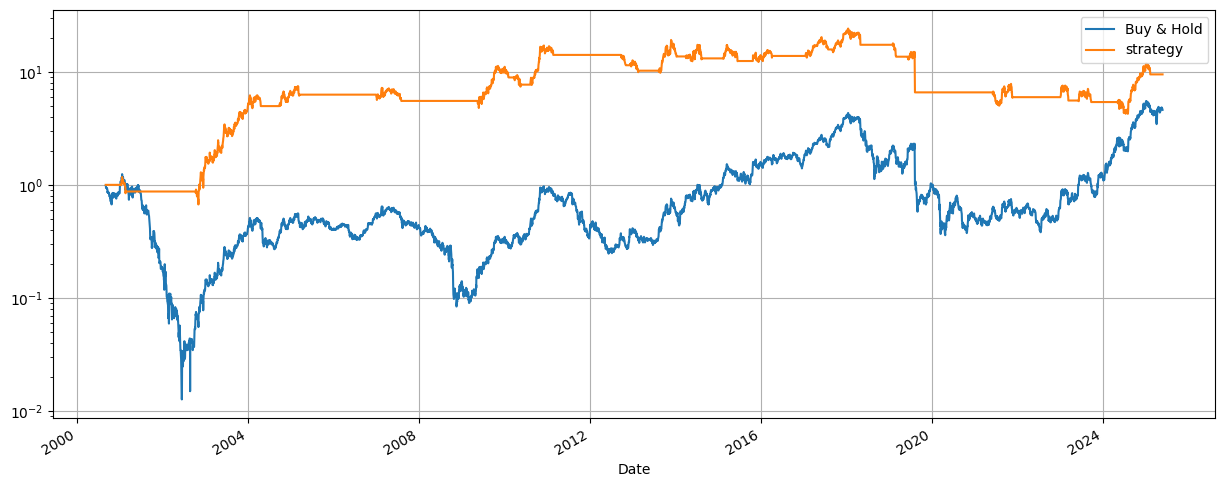

In [ ]:
# Preparo base 100 de HODL y estrategia
res_buyHold = (final['pct_change']+1).cumprod()
res_st = (final['strategy']+1).cumprod()

# Concateno ambos
compare = pd.concat([res_buyHold.rename('Buy & Hold'), res_st], axis=1)

# Ploteo
compare.plot(figsize=(15,6), logy=True, grid=True)

<Axes: xlabel='Date'>

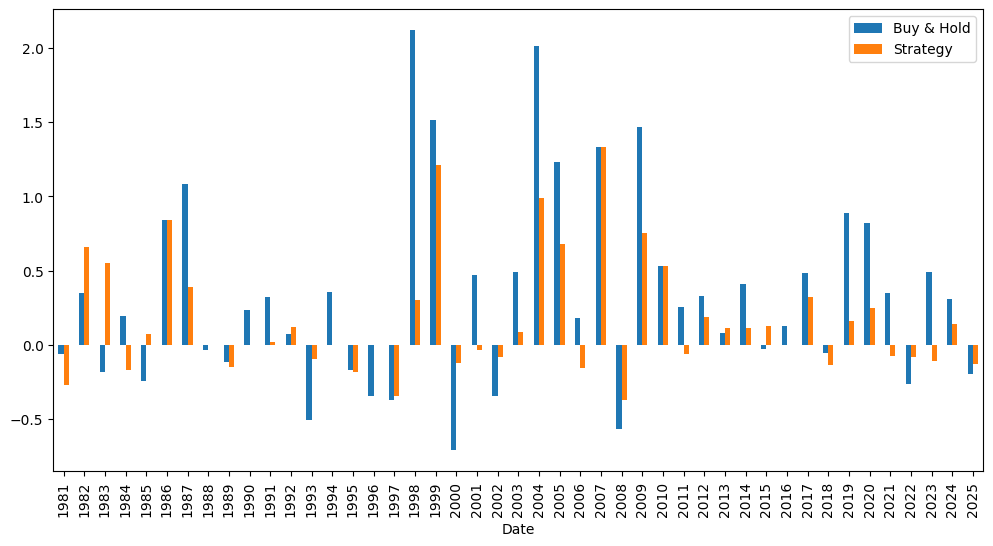

In [ ]:
returns = final.loc[: , ['pct_change','strategy']]
returns.columns = ["Buy & Hold", "Strategy"]
yoy = returns.add(1).groupby(returns.index.year).prod().sub(1)

yoy.plot(figsize=(12,6), kind='bar')

# Analisis de sensibilidad básico

## Sensibilidad del "q" del RSI

In [ ]:
data = getData('TSLA')
results = []

for i_rsi in range(5,50):

    df = addSignal(data, fast=20, slow=60, rsi_q= i_rsi , buy_cr=2, buy_rsi=65, sell_cr=0, sell_rsi=35).dropna()
    actions = getActions(df, tipo='long')
    trades = getTrades(actions,  tipo='long')
    r, metricas = resumen(trades)

    results.append(metricas)

df = pd.DataFrame(results, index=range(5,50))

In [ ]:
df.loc[df.dias_in>0].head(5)

,rendimiento,dias_in,TEA
5,8.6716,2844,0.3381
6,10.1965,2874,0.3590
7,7.4501,2899,0.3083
8,7.4717,2913,0.3070
9,8.2184,3055,0.3039


In [ ]:
df.idxmax()

,0
rendimiento,42
dias_in,33
TEA,15


Text(0.5, 0, 'Valor parametrizable del RSI')

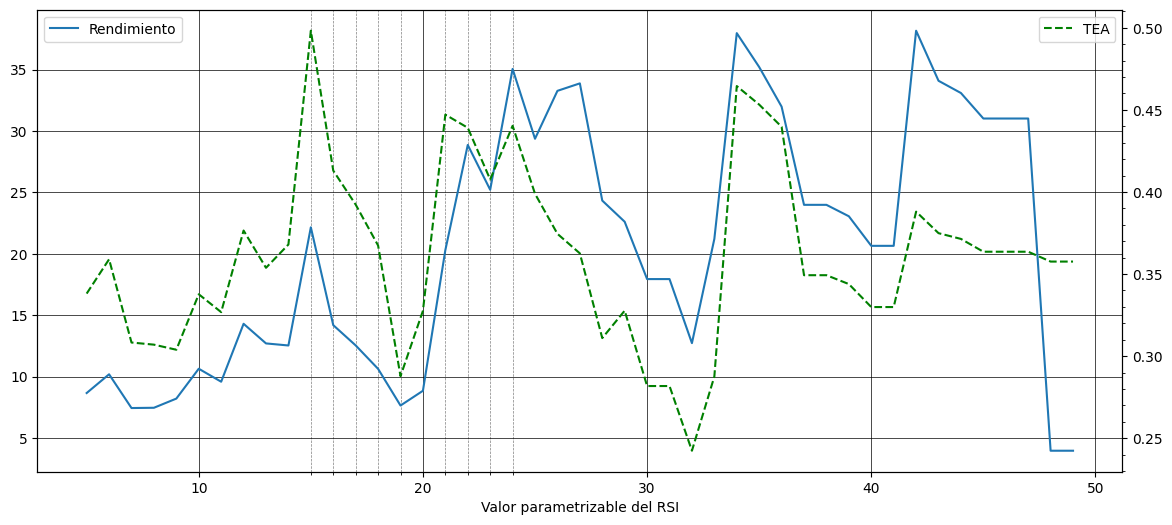

In [ ]:
import matplotlib.pyplot as plt

dfok = df.loc[df.dias_in>0].copy()

fig, ax = plt.subplots(figsize=(14,6))

ax.plot(dfok.rendimiento, label='Rendimiento')
ax.legend(loc='upper left')

ax2 = ax.twinx()
ax2.plot(dfok.TEA, 'g--', label='TEA')
ax2.legend(loc='upper right')

plt.minorticks_on()
ax.set_xticks(np.arange(15,25,1),minor=True)
ax.grid(which='major', axis='both', color='k', lw=0.5, linestyle='-')
ax.grid(which='minor', color='gray', lw=0.5, linestyle='--')
ax.set_xlabel('Valor parametrizable del RSI')

## Sensibilidad del RSI señal compra

In [ ]:
data = getData('AAPL')
results = []

for i in range(25,75):
    df = addSignal(data, fast=20, slow=60, rsi_q=24, buy_cr=2, buy_rsi=i, sell_cr=0, sell_rsi=35).dropna()
    actions = getActions(df, tipo='long')
    trades = getTrades(actions,  tipo='long')
    r, metricas = resumen(trades)

    results.append(metricas)

df = pd.DataFrame(results, index=range(25,75))

In [ ]:
df.loc[df.dias_in>0].idxmax()

,0
rendimiento,69
dias_in,25
TEA,73


Text(0.5, 0, 'Valor del RSI que activa compra')

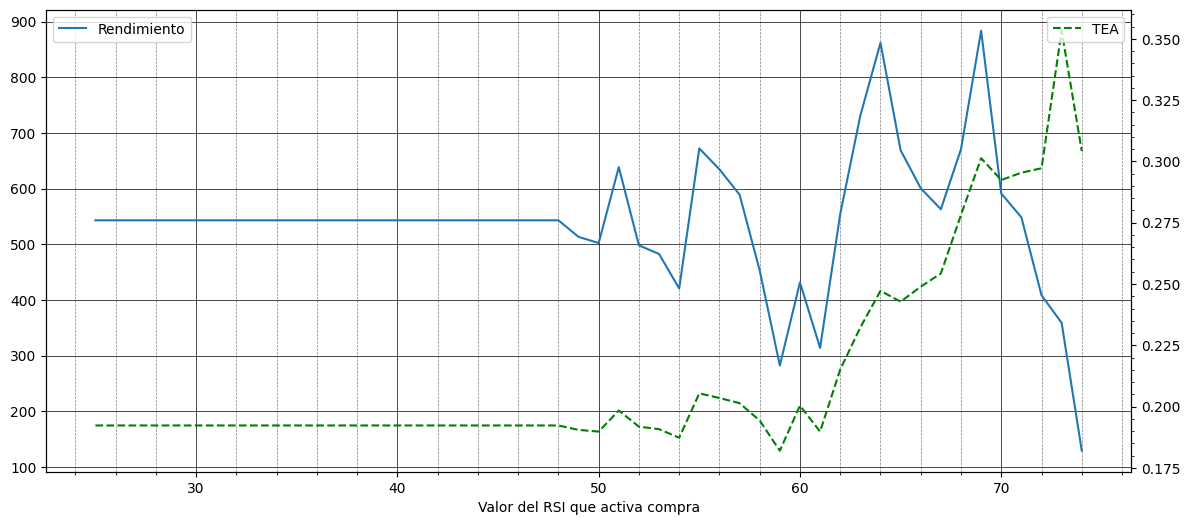

In [ ]:
import matplotlib.pyplot as plt

dfok = df.loc[df.dias_in>0].copy()

fig, ax = plt.subplots(figsize=(14,6))
ax.plot(dfok.rendimiento, label='Rendimiento')
ax.legend(loc='upper left')

ax2 = ax.twinx()
ax2.plot(dfok.TEA, 'g--', label='TEA')
ax2.legend(loc='upper right')

plt.minorticks_on()
ax.grid(which='major', axis='both', color='k', lw=0.5, linestyle='-')
ax.grid(which='minor', color='gray', lw=0.5, linestyle='--')
ax.set_xlabel('Valor del RSI que activa compra')

# Analisis de Portabilidad Básico

In [ ]:
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp500_tickers = list(sp500.Symbol)
sp500_tickers = [e.replace('.','-') for e in sp500_tickers]
data_sp500 = yf.download(sp500_tickers, start='1980-01-01')['Close']

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  503 of 503 completed


In [ ]:
from tqdm.notebook import tqdm

results = []
for ticker in tqdm(sp500_tickers):
    try:
        data = pd.DataFrame(data_sp500[ticker].copy())
        data.columns = ['close']

        df = addSignal(data, fast=20, slow=60, rsi_q=20, buy_cr=2, buy_rsi=60, sell_cr=0, sell_rsi=35).dropna()
        actions = getActions(df, tipo='long')
        trades = getTrades(actions, tipo='long')
        r, metricas = resumen(trades)
        metricas['ticker'] = ticker
        results.append(metricas)
    except:
        print("\n" + "*" * 50 + "\nError con", ticker, "\n" + "*" * 50)

results_df = pd.DataFrame(results)

# Filtro las que estuvieron al menos 1000 dias in:
results_df = results_df.loc[results_df.dias_in > 1000].sort_values('TEA', ascending=True).copy()
results_df

  0%|          | 0/503 [00:00<?, ?it/s]

,rendimiento,dias_in,TEA,ticker
336,-0.6257,2753,-0.1222,NWS
278,-0.3221,1710,-0.0796,KHC
275,-0.4668,2786,-0.0791,KMI
335,-0.3895,2793,-0.0625,NWSA
344,-0.3979,2911,-0.0616,NCLH
...,...,...,...,...
407,391.4987,6554,0.3946,SBAC
347,1422.8851,7000,0.4603,NVDA
333,2916.2380,5958,0.6303,NFLX
167,108.8585,3037,0.7590,ENPH


In [ ]:
spy = yf.download('^GSPC', start='1980-01-01')['Close']
years = (spy.index[-1] - spy.index[0]).days/365
sp500_tir = (spy.iloc[-1] / spy.iloc[0])**(1/years)-1
sp500_tir.values[0]

[*********************100%***********************]  1 of 1 completed


np.float64(0.09258237372990297)

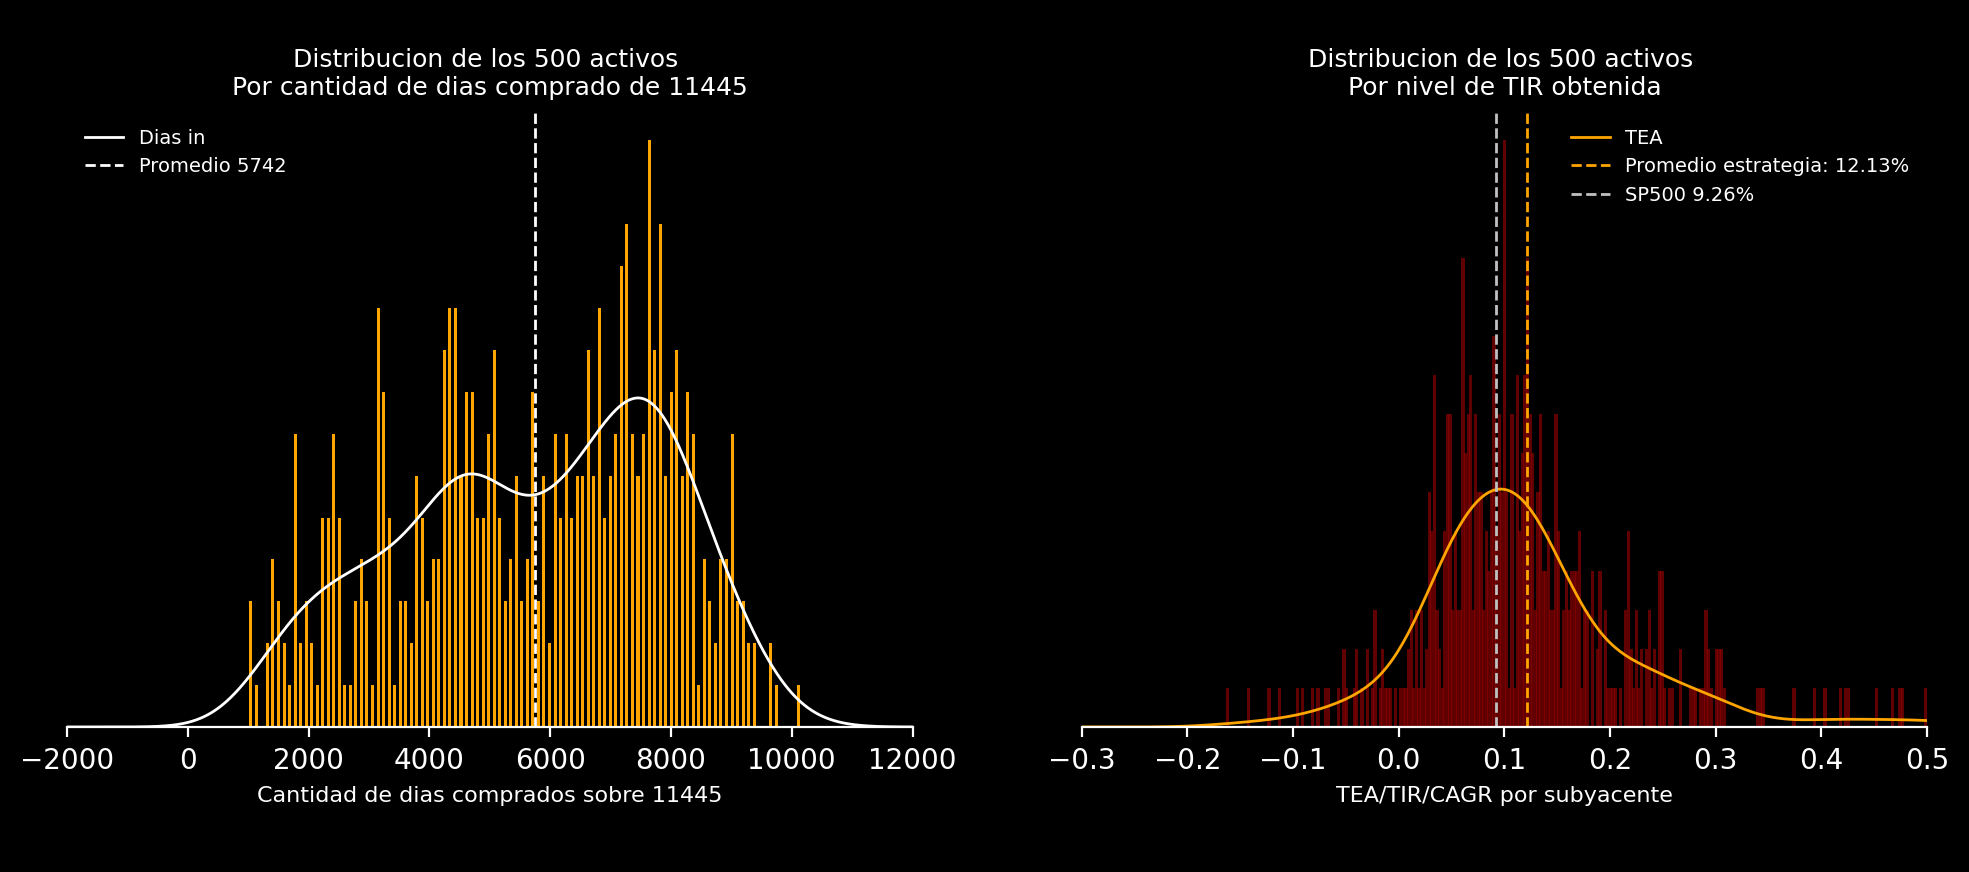

In [ ]:
plt.style.use('dark_background')
plt.rcParams['figure.dpi'] = 200
fig, ax = plt.subplots(ncols=2, figsize=(12,4))

results_df = results_df.loc[results_df.dias_in > 0]
resok = results_df.dropna()

ax[0].hist(results_df.dias_in, bins=100, color='orange', width=50, density=True)
ax[0].set_xlim(-2000,12000)
results_df.dias_in.plot(kind='kde', color='white', ax=ax[0], lw=1, label='Dias in')
ax[0].yaxis.set_visible(False)
ax[0].yaxis.set_tick_params(which='both', left=False)
ax[0].spines[['left','top','right']].set_visible(False)
ax[0].axvline(results_df.dias_in.mean(), color='white', ls='--', lw=1, label=f'Promedio {results_df.dias_in.mean():.0f}')
ax[0].set_xlabel(f'Cantidad de dias comprados sobre {len(data_sp500)}\n\n', fontsize=8)
ax[0].set_title(f'\nDistribucion de los 500 activos \nPor cantidad de dias comprado de {len(data_sp500)}', fontsize=9)
ax[0].legend(frameon=False, fontsize=7, loc='upper left')


ax[1].hist(results_df.TEA, bins=500, color='darkred', width=0.003, alpha=0.7, density=True)
ax[1].set_xlim(-0.3,0.5)
results_df.TEA.plot(kind='kde', color='orange', ax=ax[1],lw=1, label='TEA')
ax[1].yaxis.set_visible(False)
ax[1].yaxis.set_tick_params(which='both', left=False)
ax[1].spines[['left','top','right']].set_visible(False)
ax[1].axvline(results_df.TEA.mean(), color='orange', ls='--', lw=1, label=f'Promedio estrategia: {results_df.TEA.mean():.2%}')
ax[1].axvline(sp500_tir.values[0], color='silver', ls='--', lw=1, label=f'SP500 {sp500_tir.values[0]:.2%}')
ax[1].set_xlabel(f'TEA/TIR/CAGR por subyacente\n\n', fontsize=8)
ax[1].set_title(f'\nDistribucion de los 500 activos \nPor nivel de TIR obtenida', fontsize=9)
ax[1].legend(frameon=False, fontsize=7, loc='upper right')

plt.show()